# CMPINF 1205 Final Project
## Measuring Readability and Obfuscation of Privacy Policies in the OPP-115 Dataset
By Griffin Hurt

----

### Introduction
TODO

### Loading in the Data
The OPP-115 dataset is provided in several different formats, but the easiest to parse in Python will most likely be the sanitized HTML versions. BeautifulSoup is a Python library built for parsing HTML, and we will use it here to extract text from the policies. There are some extraneous characters in the dataset (specifically "|||") and sequences of multiple spaces, so we have to remove those before adding the policy to the dataframe.

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import os
import re

# Pandas dataframe with privacy policy data
policies = pd.DataFrame(columns=["Website", "Policy Content"])

# For each policy file...
for policy_file in os.listdir("data/opp_115"):
    # Open it
    with open("data/opp_115/" + policy_file, "r") as f:
        # Parse it
        soup = BeautifulSoup(f.read(), "html.parser")
    # Get the text
    html_text = soup.get_text()
    # Remove the bars
    html_text = html_text.replace("|||", "")
    # Remove multiple spaces
    html_text = re.sub(r"\s+", " ", html_text)
    # Get the name of the website
    website_name = policy_file.split("_")[1][:-5]
    # Add it to the dataframe
    policies.loc[len(policies.index)] = [website_name, html_text] 

# Display the first 5 elements of the dataframe
policies.head()

,Website,Policy Content
0,latinpost.com,"Privacy Policy Last Modified: March 25, 2013 T..."
1,google.com,Welcome to the Google Privacy Policy When you...
2,austincc.edu,Web Privacy Statement Austin Community Colleg...
3,pbs.org,Privacy Policy PBS is committed to protecting ...
4,usa.gov,"Privacy, Security, and Accessibility Policies ..."


We now have the websites' privacy policies loaded into the "Policy Content" column and are ready to begin calculating metrics about their content.

### Flesch Reading Ease
The first metric we will be analyzing the dataset with is Flesch Reading Ease, which is a number between 0 and 100 that indicates what age a person must be to understand a text.

The formula for Flesch Reading Ease is:
$$FRE(w, s, y) = 206.835 - 1.015(\frac{w}{s}) - 84.6(\frac{y}{w})$$
Where $w$ represents the number of words in the text, $s$ represents the number of sentences, and $y$ represents the number of syllables.

The Flesch Reading Ease score can then be associated with a grade level understanding:
<table>
    <tr><th>Score</th><th>School Level</th></tr>
    <tr><td>100 - 90</td><td>5th Grade</td></tr>
    <tr><td>90 - 80</td><td>6th Grade</td></tr>
    <tr><td>80 - 70</td><td>7th Grade</td></tr>
    <tr><td>70 - 60</td><td>8th and 9th Grade</td></tr>
    <tr><td>60 - 50</td><td>10th to 12th Grade (High School)</td></tr>
    <tr><td>50 - 40</td><td>College</td></tr>
    <tr><td>30 - 0</td><td>College Graduate</td></tr>
</table>

[[Source]](https://web.archive.org/web/20160712094308/http://www.mang.canterbury.ac.nz/writing_guide/writing/flesch.shtml)

Let's calculate the Flesch Reading Ease for each policy in the dataset.

In [2]:
import pronouncing

for index, row in policies.iterrows():
    # Get the sentences
    sentences_found = re.findall(r"(([A-Z]\w+) [^\.]+\.)+", row["Policy Content"])
    sentences = []
    for sentence in sentences_found:
        sentences.append(sentence[0])
    # Count the number of sentences
    num_sentences = len(sentences)
    # Get the number of syllables / words
    num_syllables = 0
    num_words = 0
    for sentence in sentences:
        words = sentence.split(" ")
        for word in words:
            phones = pronouncing.phones_for_word(word)
            # Check to make sure it's a word
            if len(phones) > 0:
                # Add words and syllables
                num_words += 1
                num_syllables += pronouncing.syllable_count(phones[0])
    # Calculate Flesch Reading Ease
    fre = 206.835 - 1.015*(num_words / num_sentences) - 84.6*(num_syllables / num_words)
    # Add it to the dataframe
    policies.at[index, "Flesch Reading Ease"] = fre

# Display the dataframe
policies.head()

,Website,Policy Content,Flesch Reading Ease
0,latinpost.com,"Privacy Policy Last Modified: March 25, 2013 T...",35.964811
1,google.com,Welcome to the Google Privacy Policy When you...,38.059614
2,austincc.edu,Web Privacy Statement Austin Community Colleg...,33.119489
3,pbs.org,Privacy Policy PBS is committed to protecting ...,43.740964
4,usa.gov,"Privacy, Security, and Accessibility Policies ...",40.874814


We have now calculated the Flesch Reading Ease for every privacy policy. Let's calculate some basic statistics (mean, median, standard deviation) on the metric.

In [3]:
mean = policies["Flesch Reading Ease"].mean()
median = policies["Flesch Reading Ease"].median()
std_dev = policies["Flesch Reading Ease"].std()

print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std_dev)

Mean: 41.57538889132636
Median: 42.004027381054584
Standard Deviation: 7.239166693762004


We see that the average Flesch Reading Index for the privacy policies is around 42. Let's also plot this data on a histogram to see the distribution of scores.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x131ab3760>]],
      dtype=object)

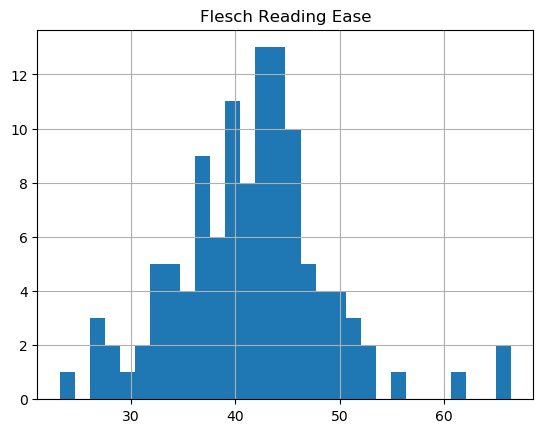

In [4]:
policies.hist("Flesch Reading Ease", bins=30)

Remember that COPPA allows the collection of data from children as young as 13 (8th grade), so to understand a policy, its score should be in the 60s or 70s. Let's see how many policies fit that requirement.

In [5]:
coppa_policies = policies[policies["Flesch Reading Ease"] > 60]
coppa_policies

,Website,Policy Content,Flesch Reading Ease
10,ticketmaster.com,Live Nation Entertainment Privacy Policy - You...,66.389168
13,dogbreedinfo.com,Privacy Policy Dog Breed Info Center does not ...,61.862595
86,sci-news.com,Privacy Policy Sci-News.com is committed to pr...,65.528684


There are only three websites with policies in the 60s: ticketmaster.com, dogbreedinfo.com, and sci-news.com. That is a miniscule 2.6% of the data sample. There are no policies in the 70s or above.

Let's take a look at the worst policies in the dataset for readability.

In [6]:
policies_sorted = policies.sort_values("Flesch Reading Ease")
policies_sorted.head()

,Website,Policy Content,Flesch Reading Ease
87,abcnews.com,Privacy Policy The Walt Disney Company has a ...,23.248971
42,playstation.com,"Privacy Policy Last Revised: April, 2011 Sony...",26.417748
74,thehill.com,THE HILL'S PRIVACY POLICY This Privacy Policy...,27.381359
23,neworleansonline.com,"Privacy Statement Last Updated on May 22, 2015...",27.436089
8,dcccd.edu,Privacy and Security Commitment Our Promise t...,28.502535


We see that abcnews.com, playstation.com, and thehill.com are the three worst privacy policies for readability. All of these policies fall in the "college graduate" section of the Flesch Reading Ease.

Based on the Flesch Reading Ease metric, most privacy policies are not able to be read by 13 year olds, despite the law allowing these children to give away their data to corporations.

### Time to Read

Another metric commonly used to measure the "readability" of a text is Time to Read. Time to Read is the amount of time it takes for a person to read and understand a section of text.

On average, a person reads 200 words per minute, so to calculate Time to Read, we simply divide the number of words by 200:
$$TTR(w) = \frac{w}{200}$$
Where $w$ represents the number of words.

Let's calculate Time to Read in minutes for each of the privacy policies.

In [7]:
for index, row in policies.iterrows():
    # Get each sentence in the policy
    sentences_found = re.findall(r"(([A-Z]\w+) [^\.]+\.)+", row["Policy Content"])
    sentences = []
    for sentence in sentences_found:
        sentences.append(sentence[0])
    # Get the number of words in each sentence
    num_words = 0
    for sentence in sentences:
        words = sentence.split(" ")
        num_words += len(words)
    # Calculate the time to read
    policies.at[index, "Time to Read"] = num_words / 200
        
policies.head()

,Website,Policy Content,Flesch Reading Ease,Time to Read
0,latinpost.com,"Privacy Policy Last Modified: March 25, 2013 T...",35.964811,34.465
1,google.com,Welcome to the Google Privacy Policy When you...,38.059614,12.490
2,austincc.edu,Web Privacy Statement Austin Community Colleg...,33.119489,4.140
3,pbs.org,Privacy Policy PBS is committed to protecting ...,43.740964,9.765
4,usa.gov,"Privacy, Security, and Accessibility Policies ...",40.874814,4.375


Next, let's calculate basic statistics for time to read.

In [8]:
mean = policies["Time to Read"].mean()
median = policies["Time to Read"].median()
std_dev = policies["Time to Read"].std()

print("Mean:", mean, "minutes")
print("Median:", median, "minutes")
print("Standard Deviation:", std_dev, "minutes")

Mean: 10.74695652173913 minutes
Median: 10.61 minutes
Standard Deviation: 7.36671841577994 minutes


We see that the average privacy policy requires 10.7 minutes, or 10 minutes and 45 seconds, to read and comprehend. This is much longer than the average person spends signing up for a new service. Let's once again plot the data on a histogram to visualize the distribution of the dataset.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x131e18b80>]],
      dtype=object)

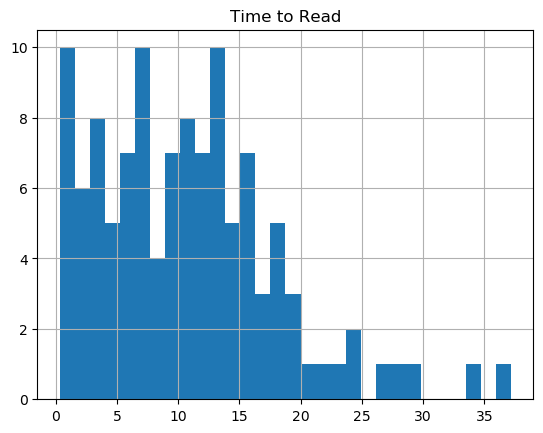

In [9]:
policies.hist("Time to Read", bins=30)

There is a noticeably high range in Time to Read across the dataset, so let's look at the best 5 and worst 5 websites for Time to Read.

In [10]:
best_ttr = policies.sort_values("Time to Read")
best_ttr.head()

,Website,Policy Content,Flesch Reading Ease,Time to Read
41,naturalnews.com,Privacy Policy NaturalNews.com never rents or ...,55.122353,0.340
81,tangeroutlet.com,Privacy Policy TangerOutlets is committed to k...,33.260616,0.405
44,solarviews.com,Privacy Statement We allow third-party compani...,44.169000,0.410
48,eatchicken.com,Privacy Policy For each visitor to our Web sit...,42.246346,0.900
63,communitycoffee.com,PRIVACY STATEMENT OUR COMMITMENT TO PROTECTIN...,40.177500,0.985


The websites with the shortest to read privacy policies are naturalnews.com (20.4 seconds), tangeroutlet.com (24.3 seconds), and solarviews.com (24.6 seconds). Policies of this length could reasonably be read by someone as they are signing up for a service, especially when their private data is on the line.

In [11]:
worst_ttr = policies.sort_values("Time to Read", ascending=False)
worst_ttr.head()

,Website,Policy Content,Flesch Reading Ease,Time to Read
82,barnesandnoble.com,"Privacy Policy Effective Date: April 1, 2015 ...",37.314168,37.170
0,latinpost.com,"Privacy Policy Last Modified: March 25, 2013 T...",35.964811,34.465
47,honda.com,"STATEMENT OF PRIVACY ( 12/23/2014, UNITED STAT...",46.232042,29.565
73,kaleidahealth.org,NOTICE OF PRIVACY PRACTICES THIS NOTICE DESCR...,44.753620,27.515
59,rockstargames.com,"Last updated on October 1, 2013 Rockstar Games...",37.532000,27.335


The websites with the longest privacy policies are barnesandnoble.com (37 minutes and 10 seconds), latinpost.com (34 minutes and 28 seconds), and honda.com (29 minutes and 34 seconds).

Overall, the average privacy policy is far too long for a user to read as they are casually signing up for a new service.

### Common Language Synonym Frequency (CLSF)

The Common Langage Synonym Frequency (CLSF) is a metric I created for this project to determine whether a word or sentence is needlessly verbose.

More formally,
$$ CLSF(o) = \frac{1}{|S|}\sum_{x \in S}{\frac{f(x)}{f(o)}} $$
Where $o$ is the original word, $S$ is the set containing its synonyms, and $f(x)$ represents the frequency of word $x$.

A lower CLSF suggests that a word will be better understood by the average person.

#### Calculating Word Frequency

One of the most important parts of the CLSF is having access to the frequency of a word and its synonyms. Luckily, there is a [publically accessible dataset of the top 333,333 most commonly used English words and their frequency values](https://www.kaggle.com/datasets/rtatman/english-word-frequency). We will load in that dataset for 

In [13]:
# Load in the word frequency dataset
word_freq = pd.read_csv("data/unigram_freq.csv")

# Calculate the respective frequency data for each word
word_freq["frequency"] = word_freq["count"] / word_freq["count"].sum()

word_freq.head()

,word,count,frequency
0,the,23135851162,0.039338
1,of,13151942776,0.022363
2,and,12997637966,0.022100
3,to,12136980858,0.020637
4,a,9081174698,0.015441


Let's write a helper function to get the frequency of a word and try it out.

In [14]:
def get_word_freq(word):
    # Lowercase for consistency
    word = word.lower()
    # Remove any special characters
    word = re.sub(r'\W+', '', word)
    word_f = word_freq[word_freq["word"] == word]
    if not word_f.empty:
        return float(word_f["frequency"])
    else:
        return 0

print("'Hello' has frequency", get_word_freq("hello"))
print("'World' has frequency", get_word_freq("world"))
print("'The' has frequency", get_word_freq("the"))
print("'NotAWord' has frequency", get_word_freq("NotAWord"))

'Hello' has frequency 5.6043230101150934e-05
'World' has frequency 0.0007344269019607154
'The' has frequency 0.03933837507090547
'NotAWord' has frequency 0


#### Sentence Parsing and Synonym Identification

For instance, "survey" could be considered a synonym of "map" when it acts as a verb, but not when it acts as a noun. In order to fix this, we 

In [15]:
from nltk.corpus import wordnet

syns = wordnet.synsets("program")

print(syns)

[Synset('plan.n.01'), Synset('program.n.02'), Synset('broadcast.n.02'), Synset('platform.n.02'), Synset('program.n.05'), Synset('course_of_study.n.01'), Synset('program.n.07'), Synset('program.n.08'), Synset('program.v.01'), Synset('program.v.02')]
